# **Import Dataset and Libraries**

In [147]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from folium.plugins import HeatMap
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np
import folium
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Change File Location
df = pd.read_csv("C:/Users/aidan_000/Desktop/UNCC/ML Project/Datasets/df6.csv", low_memory=False)

coordinates = pd.DataFrame(df[ ['ZIP', 'LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC', 'HIGHEST_NIBRS_DESCRIPTION']].values, columns= ['ZIP', 'LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC', 'HIGHEST_NIBRS_DESCRIPTION'])
df.head()

,ZIP,LATITUDE_PUBLIC,LONGITUDE_PUBLIC,Year,Month,Day,DayOfWeek,CMPD_PATROL_DIVISION,LOCATION_TYPE_DESCRIPTION,PLACE_TYPE_DESCRIPTION,...,PctHome_Ownership,HighSchool,NonWhite,F65_,Poverty,Home_Ownership,Score,VulnerableBinary,Violent-Crime,People
0,28215.0,35.258195,-80.726229,2023,12,4,0,1,1,1,...,0.75,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0,63548.0
1,28213.0,35.283274,-80.762293,2023,12,4,0,2,1,2,...,0.76,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0,44553.0
2,28210.0,35.153683,-80.839845,2023,12,4,0,5,3,4,...,0.53,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0,48214.0
3,28227.0,35.221991,-80.814908,2023,12,4,0,6,1,4,...,0.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,58524.0
4,28216.0,35.362708,-80.854438,2023,12,4,0,7,0,4,...,0.40,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1,51477.0


# **Pre-processing**

In [113]:
df['HIGHEST_NIBRS_DESCRIPTION'] = LabelEncoder().fit_transform(df['HIGHEST_NIBRS_DESCRIPTION'])

y = df.pop('HIGHEST_NIBRS_DESCRIPTION').values
x = df.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

X_train = StandardScaler().fit_transform(x_train)
X_test = StandardScaler().fit_transform(x_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# **Model Declaration and Instantiation**

In [114]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model
class SpatiotemporalModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SpatiotemporalModel, self).__init__()
        self.conv1d = nn.Conv1d(input_size, 32, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(32, 50, batch_first=True)
        self.fc = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)  # Add a channel dimension for Conv1d
        x = F.relu(self.conv1d(x))
        x, _ = self.lstm(x.permute(0, 2, 1))  # LSTM expects input in (batch, seq_len, features) format
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        return x

# Instantiate the model for multi-class classification (46 classes)
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))  # Number of classes
model = SpatiotemporalModel(input_size, output_size).to(device)

# Use CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Move both inputs and labels to the device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    all_predictions = []
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted_labels = torch.max(outputs, 1)
            all_predictions.extend(predicted_labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
 
    val_accuracy = correct / total
    
    
    end_time = time.time()
    epoch_time = end_time - start_time

    # Print epoch information
    print(f"Epoch {epoch + 1}/{epochs}, Time: {epoch_time:.2f}s, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10, Time: 14.02s, Validation Accuracy: 0.4367
Epoch 2/10, Time: 15.33s, Validation Accuracy: 0.4427
Epoch 3/10, Time: 14.97s, Validation Accuracy: 0.4475
Epoch 4/10, Time: 14.78s, Validation Accuracy: 0.4501
Epoch 5/10, Time: 14.56s, Validation Accuracy: 0.4518
Epoch 6/10, Time: 15.13s, Validation Accuracy: 0.4534
Epoch 7/10, Time: 14.34s, Validation Accuracy: 0.4544
Epoch 8/10, Time: 14.49s, Validation Accuracy: 0.4553
Epoch 9/10, Time: 14.14s, Validation Accuracy: 0.4567
Epoch 10/10, Time: 14.18s, Validation Accuracy: 0.4574


In [132]:
prediction_df = pd.DataFrame({
    'ZIP': x_test[:, 0],
    'LATITUDE_PUBLIC': x_test[:, 1],
    'LONGITUDE_PUBLIC': x_test[:, 2],
    'HIGHEST_NIBRS_DESCRIPTION': all_predictions
})

# **Data Visualization**

Most Important Features

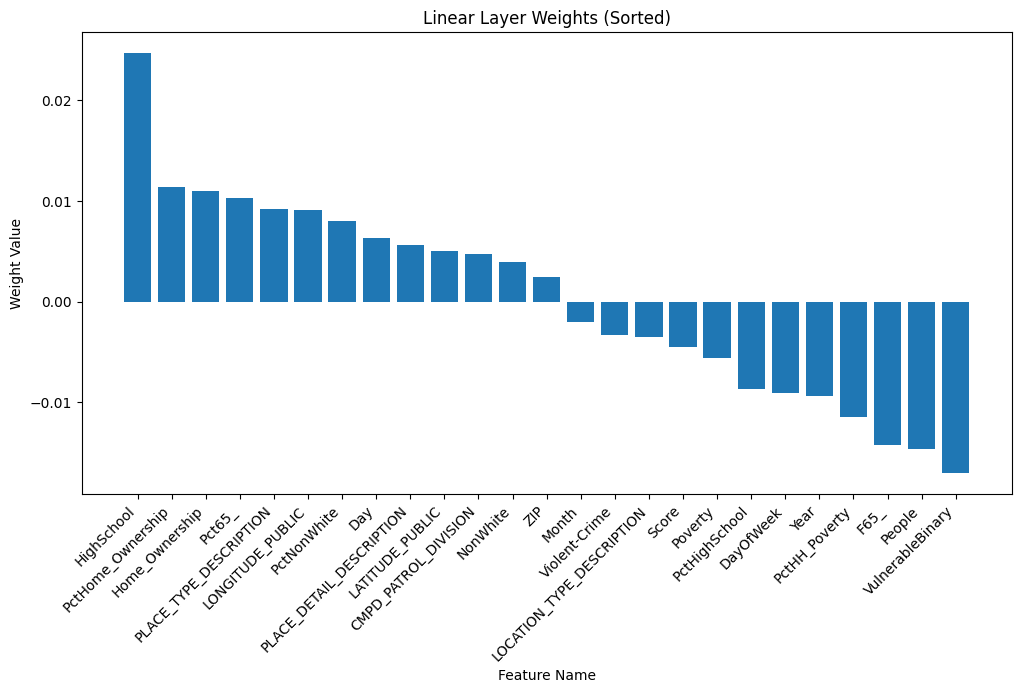

In [116]:
feature_names = df.columns
# Extract weights at the end of training
with torch.no_grad():
    final_weights = model.conv1d.weight[:, :25, 0].cpu().numpy()

weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': np.mean(final_weights, axis=0)})

weights_df = weights_df.sort_values(by='Weight', ascending=False)

# Plotting feature importance with labels
plt.figure(figsize=(12, 6))
plt.bar(weights_df['Feature'], weights_df['Weight'])
plt.xlabel('Feature Name')
plt.ylabel('Weight Value')
plt.title('Linear Layer Weights (Sorted)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

Confusion Matrix Plot

              precision    recall  f1-score   support

           0       0.43      0.78      0.56      8842
           1       0.26      0.17      0.21      4803
           2       1.00      0.00      0.00       795
           3       0.38      0.37      0.38      7700
           4       0.27      0.06      0.10      2841
           5       0.55      0.07      0.12      2337
           6       0.55      0.97      0.70      5927
           7       0.43      0.05      0.09      2068
           8       0.40      0.55      0.46      3839
           9       0.23      0.01      0.02      1792
          10       0.51      0.32      0.39       506
          11       0.32      0.52      0.39      2156
          12       0.65      0.95      0.77      5289
          13       0.10      0.00      0.00      1264
          14       1.00      0.00      0.00       163
          15       1.00      0.00      0.00       528
          16       0.72      0.08      0.14       334
          17       1.00    

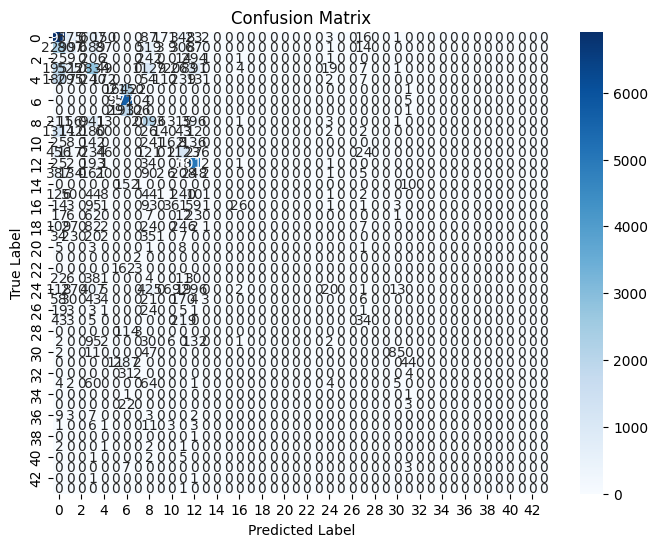

In [118]:
# Convert tensors to NumPy arrays
y_test_np = y_test_tensor.cpu().numpy()
all_predictions_np = np.array(all_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, all_predictions_np)

# Display classification report
report = classification_report(y_test_np, all_predictions_np, zero_division=1)
print(report)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Crime Prediction Map

In [141]:
minLatitude = coordinates.iloc[:, 1].min()
maxLatitude = coordinates.iloc[:, 1].max()

minLongitude = coordinates.iloc[:, 2].min()
maxLongitude = coordinates.iloc[:, 2].max()

centerLatitude = (minLatitude + maxLatitude) / 2
centerLongitude = (minLongitude + maxLongitude) / 2

PredictionMap = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=10)

# Create a base map
PredictionPoints = prediction_df[prediction_df['HIGHEST_NIBRS_DESCRIPTION'] == 1][['LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC']].head(250).values.tolist()

# Add Actual points to the map as a HeatMap layer
HeatMap(PredictionPoints, min_opacity=0.2, radius=15, blur=25, gradient={0.4: 'purple', 0.65: 'orange', 1: 'yellow'}).add_to(PredictionMap)

PredictionMap.save('PredictionMap_MultiClassModel.html')

In [139]:
ActualMap = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=10)

ActualPoints = coordinates[coordinates['HIGHEST_NIBRS_DESCRIPTION'] == 1][['LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC']].head(250).values.tolist()

# Add Actual points to the map as a HeatMap layer
HeatMap(ActualPoints, min_opacity=0.2, radius=15, blur=25, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(ActualMap)

ActualMap.save('ActualHeatmap_MultiClassModel.html')